# Sparse Gaussian Process Regression

### Salvador Medina Herrera

This example shows some of the properties of the Variational Free Energy and Fully Independent Training Conditional approaches of Gaussian Process Estimation

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import GPy
import numpy as np
import matplotlib.pyplot as plt

# Fix teh random seed
np.random.seed(100)

# Suppress tight layout warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

## Sample Function

Now we'll sample a Gaussian process regression problem directly from a Gaussian process prior.

In [2]:
N = 100 # 64
MAX_X = 10
MIN_X = 0
noise_var = 0.05

X = np.linspace(MIN_X, MAX_X,num=N)[:,None]
k = GPy.kern.RBF(1)
y = np.random.multivariate_normal(np.zeros(N),k.K(X)+np.eye(N)*np.sqrt(noise_var)).reshape(-1,1)

## Full Gaussian Process Fit

Now we optimize the parameters of a Gaussian process given the sampled data with no approximations.


Name : GP regression
Objective : 80.61148141585838
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |  priors
  rbf.variance             |  0.946825796828  |      +ve      |        
  rbf.lengthscale          |   1.29707050694  |      +ve      |        
  Gaussian_noise.variance  |  0.219065731327  |      +ve      |        


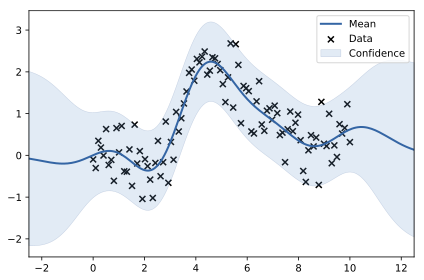

In [3]:
m_full = GPy.models.GPRegression(X,y)
m_full.optimize('bfgs')
m_full.plot()
print(m_full)

## Basic Sparse Gaussian Process Fit

Now we construct a sparse Gaussian process. This model uses the inducing variable approximation.


Name : sparse_gp
Objective : 330.2036945004638
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  sparse_gp.               |   value  |  constraints  |  priors
  inducing_inputs          |  (6, 1)  |               |        
  rbf.variance             |     1.0  |      +ve      |        
  rbf.lengthscale          |     1.0  |      +ve      |        
  Gaussian_noise.variance  |    0.05  |      +ve      |        


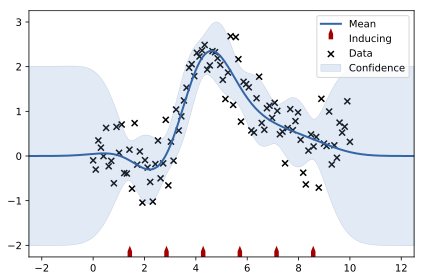

In [4]:
Z = np.linspace(MIN_X, MAX_X, 8)[1:7,None]
m_vfe = GPy.models.SparseGPRegression(X,y,Z=Z)
m_vfe.likelihood.variance = noise_var
m_vfe.plot()
print(m_vfe)


Notice how the fit is reasonable where there are inducing points, but bad elsewhere. 

### Optimizing Covariance Parameters

Next, we will try and find the optimal covariance function parameters, given that the inducing inputs are held in their current location. 


Name : sparse_gp
Objective : 87.58472544649595
Number of Parameters : 9
Number of Optimization Parameters : 3
Updates : True
Parameters:
  sparse_gp.               |           value  |  constraints  |  priors
  inducing_inputs          |          (6, 1)  |     fixed     |        
  rbf.variance             |  0.688628835607  |      +ve      |        
  rbf.lengthscale          |   1.82851040329  |      +ve      |        
  Gaussian_noise.variance  |  0.263848888142  |      +ve      |        


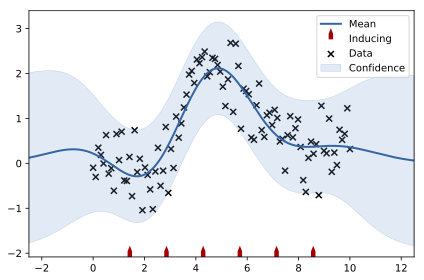

In [5]:
m_vfe.inducing_inputs.fix()
m_vfe.optimize('bfgs')
m_vfe.plot()
print(m_vfe)

The poor location of the inducing inputs causes the model to 'underfit' the data. The lengthscale is much longer than the full GP, and the noise variance is larger. This is because in this case the Kullback Leibler term in the objective free energy is dominating, and requires a larger lengthscale to improve the quality of the approximation. This is due to the poor location of the inducing inputs.

### Optimizing Inducing Inputs

Let's see what we can achieve by optimizing the position of the different inducing inputs. Now, it is evenly distributed.


Name : sparse_gp
Objective : 85.12539145587323
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  sparse_gp.               |           value  |  constraints  |  priors
  inducing_inputs          |          (6, 1)  |               |        
  rbf.variance             |   0.68547998495  |      +ve      |        
  rbf.lengthscale          |   1.60832664601  |      +ve      |        
  Gaussian_noise.variance  |  0.252765621597  |      +ve      |        


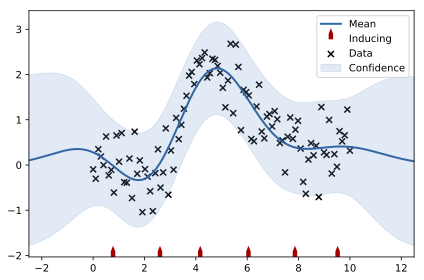

In [6]:
m_vfe.randomize()
m_vfe.Z.unconstrain()
m_vfe.optimize('bfgs')
m_vfe.plot()
print(m_vfe)

The inducing points spread out to cover the data space, but the fit isn't quite there. We can try increasing the number of the inducing points.

### Relation with the number of inducing inputs

Now we try different numbers of inducing inputs, and see how the log-likelihood evolves

In [7]:
MAX_INPUTS = 20
results_bfgs = np.zeros(MAX_INPUTS)
inducing_inputs = np.zeros(MAX_INPUTS)
for inputs in range(1, MAX_INPUTS):
    inducing_inputs[inputs] = np.random.rand() * (MAX_X - MIN_X) + MIN_X
    
    m = GPy.models.SparseGPRegression(X,y,Z=inducing_inputs[1:inputs+1,None])
    
    m.optimize('bfgs')
    
    # Add the value to the list
    results_bfgs[inputs] = m.log_likelihood()[0,0]

 /usr/lib/python3.6/site-packages/GPy/kern/src/rbf.py:35: RuntimeWarning:overflow encountered in square
 /usr/lib/python3.6/site-packages/GPy/kern/src/stationary.py:324: RuntimeWarning:invalid value encountered in true_divide


Log likelihood respect to the number of inducing inputs:


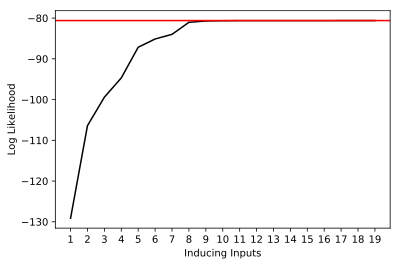

In [8]:
# Plot what we just calculated
p=plt.plot(range(1,MAX_INPUTS), results_bfgs[1:MAX_INPUTS], 'k')
plt.axhline(y=m_full.log_likelihood(), color='r')
plt.xticks(range(1,MAX_INPUTS))
plt.ylabel("Log Likelihood")
plt.xlabel("Inducing Inputs")
print("Log likelihood respect to the number of inducing inputs:")

### Results with more inducing inputs

Now we try 12 inducing points, rather than the original six. We then compare with the full Gaussian process likelihood.

Log Likelihoods:
VFE: -80.6122061562
Full Fit: -80.6114814159


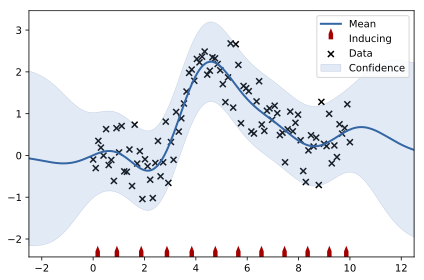

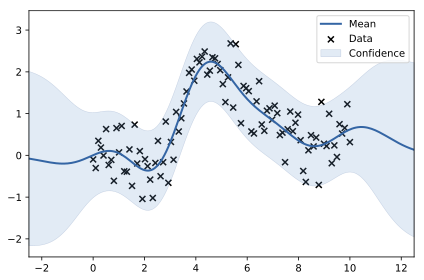

In [9]:
Z = np.random.rand(12,1) * (MAX_X - MIN_X) + MIN_X
m_vfe_12 = GPy.models.SparseGPRegression(X,y,Z=Z)

m_vfe_12.optimize('bfgs')
m_vfe_12.plot()
m_full.plot()
print("Log Likelihoods:")
print("VFE:",m_vfe_12.log_likelihood()[0,0])
print("Full Fit:",m_full.log_likelihood())

This time, we have enough inducing points and the fit resembles that of the GP.  Log likelihood for both the complete and the VFE model are similar.

## Fully Independent Training Conditional
Now, let's try using the FITC approach


Name : sparse_gp
Objective : 72.9036161067936
Number of Parameters : 9
Number of Optimization Parameters : 9
Updates : True
Parameters:
  sparse_gp.               |            value  |  constraints  |  priors
  inducing_inputs          |           (6, 1)  |               |        
  rbf.variance             |   0.569906352071  |      +ve      |        
  rbf.lengthscale          |   0.994491139374  |      +ve      |        
  Gaussian_noise.variance  |  0.0541969144007  |      +ve      |        


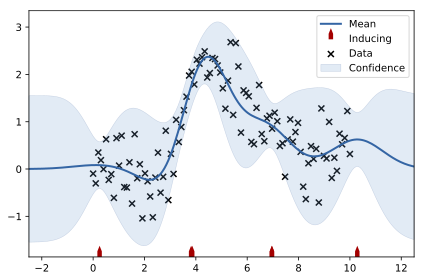

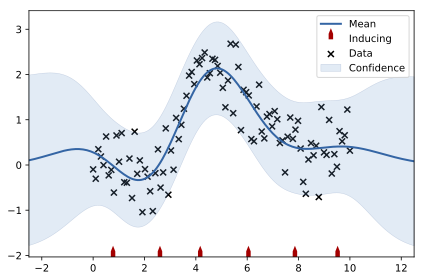

In [10]:
Z = np.linspace(MIN_X, MAX_X, 8)[1:7,None]

# Print FITC
m_fitc = GPy.models.SparseGPRegression(X, y, Z=Z)
m_fitc.inference_method=GPy.inference.latent_function_inference.FITC()
m_fitc.optimize('bfgs')
m_fitc.plot()

# Compare with VFE
m_vfe = GPy.models.SparseGPRegression(X,y,Z=Z)
m_vfe.optimize('bfgs')
m_vfe.plot()

# Print model
print(m_fitc)

Observations:
- FITC can severely underestimate the noise variance, VFE overestimates it
- See that some inputs are ignored in FITC

## Improvement with the number of inputs
Here we check how the approximation changes with the number of inducing inputs

In [11]:
MAX_INPUTS = 20
results_fitc = np.zeros(MAX_INPUTS)
inducing_inputs = np.zeros(MAX_INPUTS)
for inputs in range(1, MAX_INPUTS):
    inducing_inputs[inputs] = np.random.rand() * (MAX_X - MIN_X) + MIN_X
    
    m = GPy.models.SparseGPRegression(X,y,Z=inducing_inputs[1:inputs+1,None])
    m.inference_method=GPy.inference.latent_function_inference.FITC()
    
    m.optimize('bfgs')
    
    # Add the value to the list
    results_fitc[inputs] = m.log_likelihood()

Log likelihood respect to the number of inducing inputs:


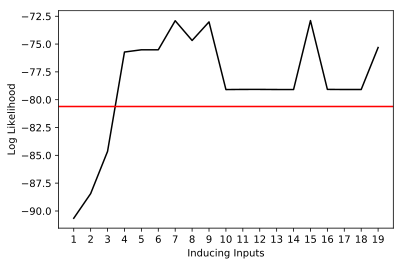

In [12]:
# Plot what we just calculated
p=plt.plot(range(1,MAX_INPUTS), results_fitc[1:MAX_INPUTS], 'k')
plt.axhline(y=m_full.log_likelihood(), color='r')
plt.xticks(range(1,MAX_INPUTS))
plt.ylabel("Log Likelihood")
plt.xlabel("Inducing Inputs")
print("Log likelihood respect to the number of inducing inputs:")

Observations:
- FITC does not recover the true posterior, VFE does
- VFE improves with additional inducing inputs, FITC may ignore them

## Recovering the true posterior:
With the whole dataset

Log Likelihoods:
VFE: -80.6114818185
FITC: -80.611472876
Full Fit: -80.6114814159


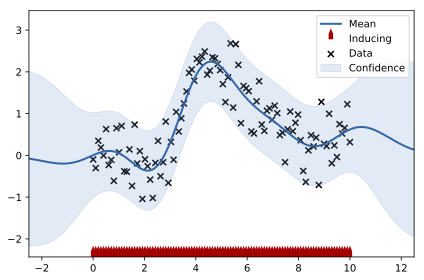

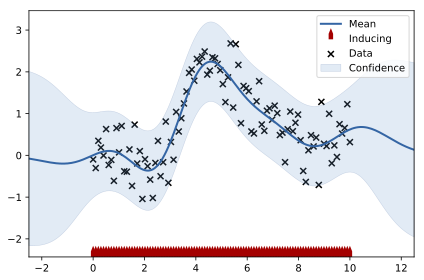

In [13]:
# Print FITC
m_fitc_full = GPy.models.SparseGPRegression(X, y, Z=X)
m_fitc_full.inference_method=GPy.inference.latent_function_inference.FITC()
m_fitc_full.optimize('bfgs')
m_fitc_full.plot()
plt.title("FITC:");

# Compare with VFE
m_vfe_full = GPy.models.SparseGPRegression(X,y,Z=X)
m_vfe_full.optimize('bfgs')
m_vfe_full.plot()
plt.title("VFE")

print("Log Likelihoods:")
print("VFE:",m_vfe_full.log_likelihood()[0,0])
print("FITC:",m_fitc_full.log_likelihood())
print("Full Fit:",m_full.log_likelihood())

With just one eight of it

Log Likelihoods:
VFE: -80.6122198421
FITC: -79.0890994987
Full Fit: -80.6114814159


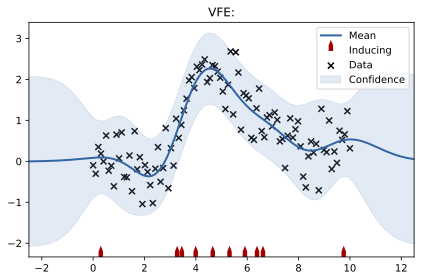

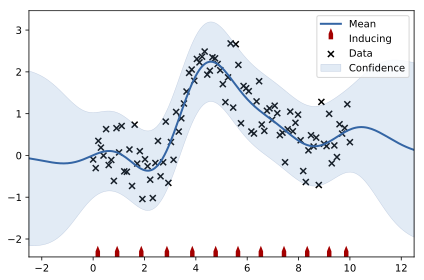

In [15]:
Z = np.linspace(MIN_X, MAX_X,num=N/8)[:,None]

# Print FITC
m_fitc_full = GPy.models.SparseGPRegression(X, y, Z=Z)
m_fitc_full.inference_method=GPy.inference.latent_function_inference.FITC()
m_fitc_full.optimize('bfgs')
m_fitc_full.plot()
plt.title("FITC:")

# Compare with VFE
m_vfe_full = GPy.models.SparseGPRegression(X,y,Z=Z)
m_vfe_full.optimize('bfgs')
m_vfe_full.plot()
plt.title("VFE:")

print("Log Likelihoods:")
print("VFE:",m_vfe_full.log_likelihood()[0,0])
print("FITC:",m_fitc_full.log_likelihood())
print("Full Fit:",m_full.log_likelihood())